# Fine Tune BERT - Multiclass Text Classification on Twitter Data
* Notebook by Adam Lang
* Date: 12/9/2024

# Overview
1. Datasets
  * Load and process dataset(s).

2. Tokenizers
  * Tokenize input text/data.

3. Transformer Models
  * Load models
  * Train or finetune model(s)
  * Use model(s) for prediction and inference.

4. Datasets
  * Load metrics
  * Evalaute models

# Text Classification Architecture
* This is the basic architecture of the model we need to fine tune.
1. Token encodings
2. Token embeddings
3. Encoder stack (BERT model)
4. Hidden states
5. **Classification head**
  * This is the most important step.
  * This is the main process of **transfer learning**:
    * Taking a pre-trained model, keeping most of its layers "frozen" (not updating their weights), and **only training the final classification layer (the "head")** to adapt it to a new, specific classification task
    * This allows you to leverage the general features learned by the pre-trained model while **fine-tuning on specific data set with minimal parameter updates.**
  * **Loss Function** This calculates the predicted error between the prediction and true values.
  * **Activation Function**
    * This applies a non-linear transformations to transform raw logits into predictions.

6. Predictions

## Key Points about the architecture

1. **Transfer learning**
* This is a very common practice in transfer learning, where a powerful model pre-trained on a large dataset is used as a starting point for a new task with a smaller dataset.

2. **Freezing layers**
* By freezing **most of the pre-trained model**, you prevent their weights from changing during training, essentially **using them as a feature extractor**.

3. **Adapting the classification head**
* The newly added or modified classification head is the **only part that learns specific information about your target classes**, allowing it to make predictions on your new data.

## Benefits
1. **Faster training**
* Training only a small part of the model is usually much faster than training the whole neural network from scratch.

2. Improved performance
* Leveraging the pre-trained features can often lead to better performance on smaller datasets, especially when the new task is related to the pre-trained task

## When to use this approach?
1. Limited Data
  * When you have "relatively small dataset" for a target classification task this technique will often perform well.
  * When there is BIG DATA that is when we would likely consider another process.

2. Similar domain
  * If the pre-trained model's domain is similar to the new task at hand this technique generally performs well.


In [1]:
## install libraries
!pip install -U transformers
!pip install -U accelerate
!pip install -U datasets
!pip install -U bertviz
!pip install -U umap-learn
!pip install seaborn --upgrade

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 27.2 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.20.3
    Uninstalling tokenizers-0.20.3:
      Successfully uninstalled tokenizers-0.20.3
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 336.3/336.3 kB 9.3 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.1.1
    Uninstalling accelerate-1.1.1:
      Successfully uninstalled accelerate-1.1.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━

# Load Multiclass Classification Dataset

In [2]:
## load dataset into df
import pandas as pd


## dataset import
df = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/All-CSV-ML-Data-Files-Download/refs/heads/master/twitter_multi_class_sentiment.csv")
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


In [3]:
## info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [4]:
## check nulls
df.isna().sum()

,0
text,0
label,0
label_name,0


In [5]:
## descrip stats
df.describe()

,label
count,16000.000000
mean,1.565937
std,1.501430
min,0.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,5.000000


In [6]:
## label value counts
df['label'].value_counts()

,count
label,
1,5362
0,4666
3,2159
4,1937
2,1304
5,572


# Exploratory Data Analysis

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:
## lets get the label counts (multi class targets)
label_counts = df['label_name'].value_counts(ascending=True)
label_counts

,count
label_name,
surprise,572
love,1304
fear,1937
anger,2159
sadness,4666
joy,5362


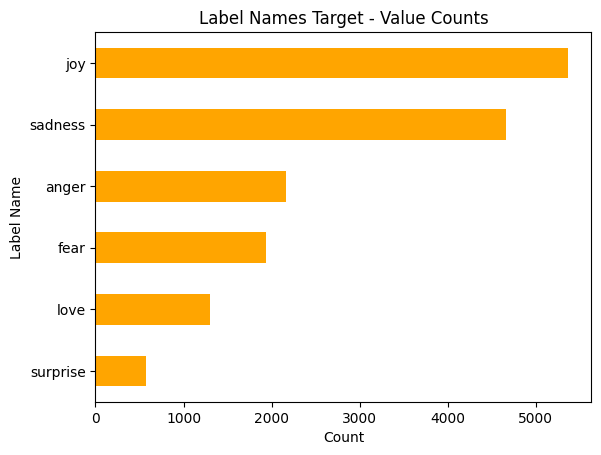

In [9]:
## plot above
label_counts.plot(kind='barh',color='orange')
plt.title("Label Names Target - Value Counts")
plt.xlabel("Count")
plt.ylabel("Label Name")
plt.show();

Summary
* Clearly we can see we are dealing with class imbalance in the target prediction variable.
* There are a few ways to handle this but for now we will let them be.

In [10]:
## lets plot the number of words per tweet
df['Words per Tweet'] = df['text'].str.split().apply(len)
df.head()

,text,label,label_name,Words per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


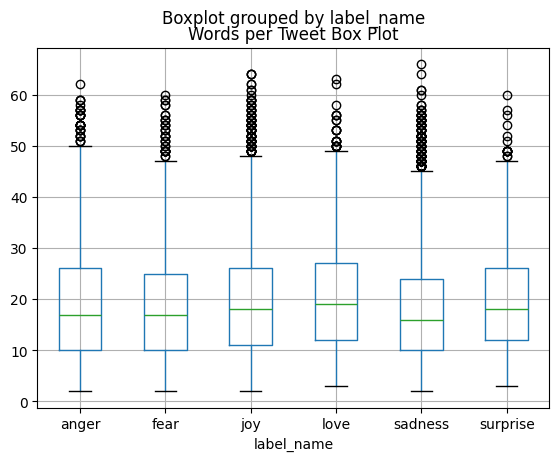

In [11]:
## plot words per tweet
df.boxplot("Words per Tweet",by="label_name")
plt.title("Words per Tweet Box Plot")
plt.show();

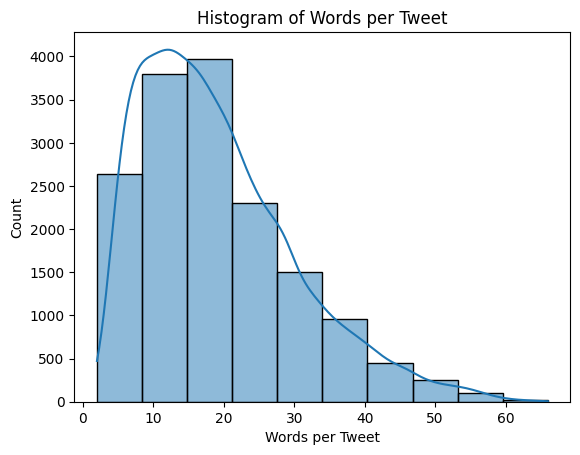

In [12]:
## histogram of tweet length
sns.histplot(df['Words per Tweet'], bins=10,kde=True).set(title="Histogram of Words per Tweet")
plt.show();

Summary
* We are mostly looking at the number of words per tweet being between 10 and 20.
* The distribution is right tailed with quite a few outliers above length of 30.

# Load Tokenizer

In [13]:
from transformers import AutoTokenizer


## setup model checkpoint
model_ckpt = "bert-base-uncased"

## setup tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [14]:
## test out tokenizer
text = "Machine learning is awesome! Deep learning is even better!"
encoded_text = tokenizer(text)

print(encoded_text)

{'input_ids': [101, 3698, 4083, 2003, 12476, 999, 2784, 4083, 2003, 2130, 2488, 999, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [15]:
## view tokenizer vocab
tokenizer.vocab

{'gough': 29124,
 'crisis': 5325,
 'carrot': 25659,
 'hq': 16260,
 '##national': 25434,
 'convex': 18309,
 '##para': 28689,
 'joins': 9794,
 'mart': 20481,
 'weakened': 11855,
 '##cise': 18380,
 '##oft': 15794,
 'enduring': 16762,
 'requires': 5942,
 'structurally': 29060,
 '276': 25113,
 'worker': 7309,
 '##yeh': 25673,
 '##38': 22025,
 '##itors': 27287,
 '[unused41]': 42,
 'indianapolis': 9506,
 'son': 2365,
 'vertices': 18984,
 'belize': 18867,
 'brunette': 27261,
 'dock': 8946,
 'baha': 13253,
 '##mo': 5302,
 '##ole': 9890,
 'reminded': 6966,
 'once': 2320,
 'wasn': 2347,
 'zheng': 20985,
 'buttons': 11287,
 'mcgrath': 23220,
 'papa': 13008,
 'proved': 4928,
 'raised': 2992,
 'spotting': 27963,
 '##eles': 26741,
 'qualifications': 15644,
 'strips': 12970,
 'bumped': 19030,
 '##ɣ': 29683,
 'branches': 5628,
 'trey': 14826,
 '##ith': 8939,
 '##ika': 7556,
 'consistency': 18700,
 '##gb': 18259,
 'bromley': 27979,
 'bree': 21986,
 'seller': 14939,
 'fluorescent': 22184,
 '##rative': 18

## Tokenizer Metrics
* We can look at specific metrics with the tokenizer.

In [16]:
## metrics of tokenizer
print(f"Length of tokenizer: {len(tokenizer.vocab)}")
print(f"Vocab size: {tokenizer.vocab_size}")
print(f"Tokenizer max length: {tokenizer.model_max_length}")

Length of tokenizer: 30522
Vocab size: 30522
Tokenizer max length: 512


# Data Loader and Train Test Split

In [17]:
## df head
df.head()

,text,label,label_name,Words per Tweet
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


## Train Test Validation Split
* Create the split

In [18]:
## setup train test split
from sklearn.model_selection import train_test_split

## init train_test_split
# 1. train/test at 70/30 split
train, test = train_test_split(df, test_size=0.3, stratify=df['label_name'])
# 2. validation set --> 1/3 of the 30% split of test set
test, validation = train_test_split(test,test_size=1/3, stratify=test['label_name'] )


## print shapes
print(f"Size of train set: {train.shape}")
print(f"Size of test set: {test.shape}")
print(f"Size of val set: {validation.shape}")

Size of train set: (11200, 4)
Size of test set: (3200, 4)
Size of val set: (1600, 4)


## DataLoader
* Create a DataLoader for huggingface datasets from our dataset.

In [19]:
## create dataloader for huggingface dataset with our data
from datasets import Dataset, DatasetDict

## Create huggingface dataset "DataLoader" --> dictionary
dataset = DatasetDict(
    {'train': Dataset.from_pandas(train, preserve_index=False),
     'test': Dataset.from_pandas(test, preserve_index=False),
     'validation': Dataset.from_pandas(validation, preserve_index=False),
     }
)


## view dataset in huggingface dataset "DataLoader" format
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

# Tokenization of Dataset
* Now we can utilize the tokenizer to tokenize the dataset.

In [20]:
## view dataset in HF format
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet'],
        num_rows: 1600
    })
})

In [21]:
## view an index
dataset['train'][0]

{'text': 'i feel you jerked a little surprised at the hand that touched you',
 'label': 5,
 'label_name': 'surprise',
 'Words per Tweet': 13}

In [22]:
## create a sort function to tokenize data
def tokenize(batch):
  temp = tokenizer(batch['text'], padding=True, truncation=True) #truncate at max length
  return temp


## test out function
print(tokenize(dataset['train'][:2]))

{'input_ids': [[101, 1045, 2514, 2017, 8245, 1037, 2210, 4527, 2012, 1996, 2192, 2008, 5028, 2017, 102], [101, 1045, 2514, 3492, 6866, 2006, 1037, 17850, 12879, 8299, 17408, 9006, 2213, 102, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]}


Summary
* We can see the `input_ids`, `token_type_ids`, and `attention_mask`.

## Tokenize the entire dataset
* Now we can tokenize the entire dataset.

In [23]:
## tokenize entire dataset
emotion_encoded = dataset.map(tokenize,
                              batched=True,
                              batch_size=None) # entire data passed without batch_size

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

In [24]:
## lets see output
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

Summary
* Now we have the tokenized data in separate columns.

## Label Mappings
* We now have to create the mappings between the following:
  * `id2label`
  * `label2id`
* **This is the most important step after tokenization that we must perform prior to training a model.**


In [25]:
## example of this
dataset['train'][0], dataset['train'][1]

({'text': 'i feel you jerked a little surprised at the hand that touched you',
  'label': 5,
  'label_name': 'surprise',
  'Words per Tweet': 13},
 {'text': 'i feel pretty posted on a href http playhousecomm',
  'label': 1,
  'label_name': 'joy',
  'Words per Tweet': 9})

Summary
* In the config file in huggingface these are stored as:
  * label --> `id2label`
  * label_name --> `label2id`

In [26]:
# label2id, id2label
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

## print both
label2id, id2label

({'surprise': 5, 'joy': 1, 'sadness': 0, 'anger': 3, 'love': 2, 'fear': 4},
 {5: 'surprise', 1: 'joy', 0: 'sadness', 3: 'anger', 2: 'love', 4: 'fear'})

# Model Building

In [27]:
## imports
from transformers import AutoModel
import torch

In [28]:
## load transformer model
model = AutoModel.from_pretrained(model_ckpt)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [29]:
## lets see model weights
model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

Summary
* We can see the neural network layers of the BERT model above.
* We can see the last layer is a linear output layer.
* Up until this point we have not added or used a classification head on the model.

In [30]:
## lets view the model config --> this gives us most info we need
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

In [31]:
## model architecture
model.config.architectures

['BertForMaskedLM']

In [32]:
## id2label call
model.config.id2label

{0: 'LABEL_0', 1: 'LABEL_1'}

# Building Classification Head on BERT Model
* `AutoModelForSequenceClassification` **automatically adds a classification head** on top of a pretrained model output via the hugging face API.
  * The first thing we need is a pretrained BERT model which we already loaded.
  * However, to make this a Classification model instead of `AutoModel` we use the `AutoModelForSequenceClassification` which more easily allows us to train a base model with a classification task or tasks.
* There are other "heads" that can be added, if we were going to go text generation we would use `AutoModelForCausalLM`.
* Other examples seen here:  https://huggingface.co/docs/transformers/en/model_doc/auto
* A note about `AutoConfig`: All model construction starts from instantiating a model configuration, which specifies the model structure (e.g., the number of layers, the number of attentions, etc). AutoConfig is used for this purpose; it automatically downloads well-known model configurations from the HF model hub.
  * See this excellent resource: https://insujang.github.io/2023-04-19/using-huggingface-transformers/

In [33]:
from transformers import AutoModelForSequenceClassification, AutoConfig

## setup num_labels -- default was 2 for model
num_labels = len(label2id)

## setup device agnostic code
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## setup config
config = AutoConfig.from_pretrained(model_ckpt, label2id=label2id, id2label=id2label)

## create model classification head
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt,
                                                           config=config).to(device) #move to device


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
## print device
device

device(type='cuda')

In [35]:
## lets review the model
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [36]:
## lets check the config again
model.config

BertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "sadness",
    "1": "joy",
    "2": "love",
    "3": "anger",
    "4": "fear",
    "5": "surprise"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 3,
    "fear": 4,
    "joy": 1,
    "love": 2,
    "sadness": 0,
    "surprise": 5
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.47.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}

Summary:
* We can now see the `label2id` and `id2label` settings.

# Build Training Arguments
* All parameters for the hugging face Trainer are listed here: https://huggingface.co/docs/transformers/main/en/main_classes/trainer

In [37]:
from transformers import TrainingArguments

# define batch_size
batch_size = 64 #change based on your data
training_dir = "bert_base_train_dir"

## create training args
training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2, #adjust this
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    evaluation_strategy='epoch',
    disable_tqdm=False,

)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


# Compute Metrics
* We can define the compute metrics from the hugging face `evaluate` library.
* documentation: https://huggingface.co/docs/evaluate/en/index

## 3 ways to do this
1. Hugging Face Evaluate library
  * see above

2. Sklearn libary

3. Torch metrics
* https://lightning.ai/docs/torchmetrics/stable/classification/accuracy.html

In [38]:
%%capture
!pip install evaluate

Method #1 - Hugging Face Compute Metrics

In [48]:
## build compute metrics using evaluate library
import evaluate
import numpy as np

## load accuracy
accuracy = evaluate.load("accuracy")

## define function to compute metrics
def compute_metrics(eval_pred):
  """Function to compute eval metrics"""
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)

  return accuracy.compute(predictions=predictions, references=labels)

Method #2 - Sklearn

In [40]:
# use sklearn to build compute metrics
from sklearn.metrics import accuracy_score, f1_score

## define function for sklearn metrics
def compute_metrics_sklearn(pred):
  """Function to compute metrics using sklearn"""
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)

  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)

  return {"accuracy": acc, "f1": f1}

Method #3 - Torchmetrics

In [41]:
%%capture
!pip install torchmetrics

In [42]:
import torchmetrics

# function to compute metrics using torch metrics
def compute_torch_metrics(pred, target):
  """
  Computes and returns accuracy, precision, and F1 score using TorchMetrics.

  Args:
    pred: Predicted labels (tensor).
    target: True labels (tensor).

  Returns:
    A dictionary containing accuracy, precision, and F1 score.
  """

  num_classes = len(label2id)  # change based on num classes

  # Initialize metrics
  accuracy = torchmetrics.classification.Accuracy(task="multiclass", num_classes=num_classes)
  precision = torchmetrics.classification.Precision(task="multiclass", average='weighted', num_classes=num_classes)
  f1_score = torchmetrics.classification.F1Score(task="multiclass", average='weighted', num_classes=num_classes)

  # Calculate metrics
  acc = accuracy(pred, target)
  prec = precision(pred, target)
  f1 = f1_score(pred, target)

  # Return as a dictionary
  metrics = {
      "accuracy": acc.item(),
      "precision": prec.item(),
      "f1_score": f1.item()
  }

  return metrics

# Build Trainer & Train Model
* By default the model will use:
  * 1. For input --> input_ids
  * 2. For output --> label
* Recall the dataset in the hugging face dict (dataloader) format below


In [46]:
emotion_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'Words per Tweet', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [49]:
from transformers import Trainer

## init trainer
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    tokenizer=tokenizer,
)

<ipython-input-49-37eea95e1cde>:4: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


By default the model will use:
* For input --> input_ids
* For output --> label

Recall the dataset in the hugging face dict (dataloader) format below

In [50]:
## now we train the model
trainer.train()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.559130,0.815625
2,No log,0.335699,0.892500


TrainOutput(global_step=350, training_loss=0.7410367257254464, metrics={'train_runtime': 361.1736, 'train_samples_per_second': 62.02, 'train_steps_per_second': 0.969, 'total_flos': 897898722739200.0, 'train_loss': 0.7410367257254464, 'epoch': 2.0})

# Model Evaluation

## Accuracy

In [51]:
## prediction on test set
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.3159838914871216,
 'test_accuracy': 0.8946875,
 'test_runtime': 17.938,
 'test_samples_per_second': 178.393,
 'test_steps_per_second': 2.787}

Summary of Evaluation
* Accuracy is ~90% which isn't bad.

We need the `np.argmax` of the raw logits of the softmax output.
* We need to know which index has the highest logits --> which is the highest probability

## Classification Report

In [54]:
## logits
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = emotion_encoded['test'][:]['label']

In [58]:
## classification report
from sklearn.metrics import classification_report
print("Classification Report")
print()
print(classification_report(y_true,y_pred))

Classification Report

              precision    recall  f1-score   support

           0       0.94      0.95      0.94       933
           1       0.89      0.94      0.92      1072
           2       0.80      0.62      0.70       261
           3       0.90      0.91      0.90       432
           4       0.87      0.87      0.87       387
           5       0.77      0.68      0.72       115

    accuracy                           0.89      3200
   macro avg       0.86      0.83      0.84      3200
weighted avg       0.89      0.89      0.89      3200



In [59]:
label2id

{'surprise': 5, 'joy': 1, 'sadness': 0, 'anger': 3, 'love': 2, 'fear': 4}

Summary:
* We can see that label 5 did not perform very well and that is validated by the poor F1 score, recall, and accuracy.
  * We can also see what we saw initially in our EDA, which was the "support" or number of samples in this target class is much lower than the other classes.
  * Thus, this is something we would want to deal with to improve our accuracy for this class and the overall model.
  * Some things we can do:
    * 1) Upsample or Downsample
    * 2) Create synthetic data using LLM
    * 3) Human annotation of real world data

## Confusion Matrix
* We will now plot the confusion matrix.

In [60]:
## plot confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

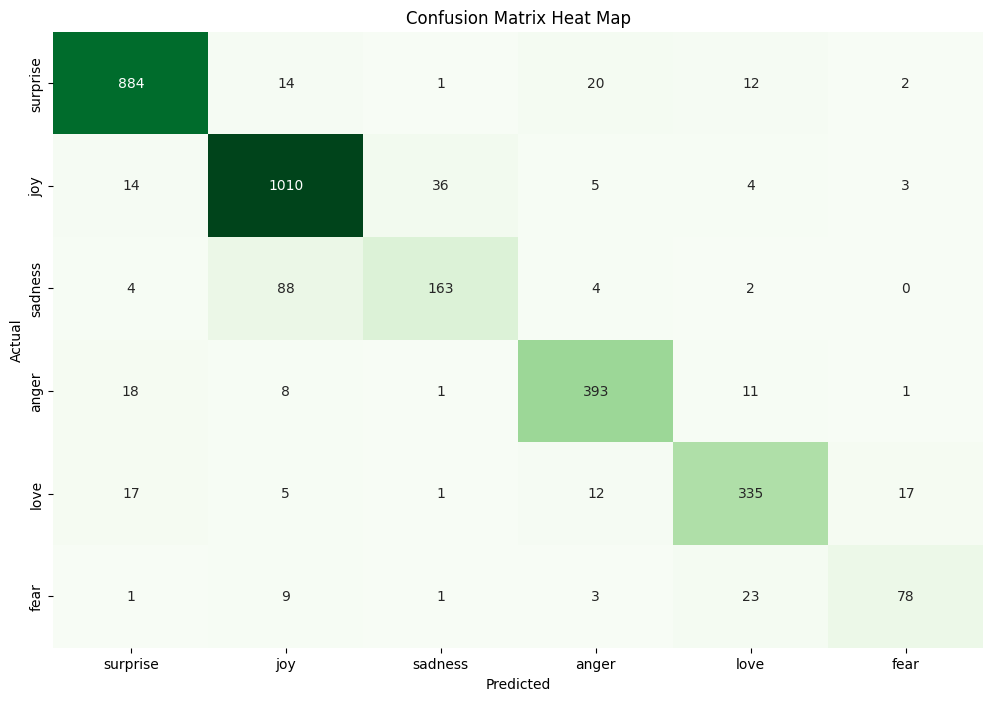

In [67]:
## get matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, xticklabels=label2id.keys(),yticklabels=label2id.keys(),
            fmt='d',
            cbar=False,
            cmap="Greens").set(title="Confusion Matrix Heat Map")
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show();

# Build Prediction Function for Inference
* Here we can run inference on our model and test out the results of its predictions.

In [74]:
## test text
text = "I am so angry today, I could scream!"


## function to get prediction
def get_preds(text):
  # 1. tokenize input
  input_encoded = tokenizer(text, return_tensors='pt').to(device)

  # 2. disable gradient calculations -> get model outputs
  with torch.no_grad():
    outputs = model(**input_encoded)

  # 3. get raw logits from model outputs
  logits = outputs.logits

  # 4. get prediction with highest logit
  pred = torch.argmax(logits, dim=1).item()
  return pred, id2label[pred]

In [75]:
## call prediction function
get_preds(text)

(3, 'anger')

# Save model

In [76]:
## save model for later usage
trainer.save_model('bert-base-uncased-sentiment-model')

# Use Pipeline for prediction

In [81]:
## use pipeline
from transformers import pipeline

## init classifier
classifier = pipeline("text-classification", model='bert-base-uncased-sentiment-model')

# classify
classifier([text,'hello, i love you!','I am so gloomy!'])

Device set to use cuda:0


[{'label': 'anger', 'score': 0.9329176545143127},
 {'label': 'joy', 'score': 0.5186254382133484},
 {'label': 'sadness', 'score': 0.9645162224769592}]

# Turn this into a Streamlit App!
* Notes:
  * It is easier to run this part of the code from an IDE like VS Code.
  * Instead of using the `%%writefile app.py`, go to VS Code and create an `app.py` file as well as a `requirements.txt` file.
  * Make sure to also create a virtual environment such as this: `python -m venv <name of your venv>`
    * Then activate your venv: `source <name of venv>/bin/activate`
    * Then install the `requirements.txt` file: `pip install -r requirements.txt`
    * Then to run the app: `streamlit run app.py`

In [87]:
%%writefile app.py

import streamlit as st
import pandas as pd
import numpy as np

# import pipeline
from transformers import pipeline

## app title
st.title("Fine Tuning BERT for Twitter Sentiment Multiclass Classification")


## here is where you load your HF pipeline with your finetuned model
classifier = pipeline("text-classification", model='<path to your model>')


## text input box
text = st.text_area("Enter your tweet for sentiment analysis: ")

## create button for user to run prediction pipeline
if st.button("Predict"):
  result = classifier(text)
  st.write(result)


Overwriting app.py
